In [1]:
import os, sys, shutil, time, os.path as osp, logging, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt, cycler
import matplotlib
from tqdm import tqdm
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Features are (x, y, z, t, E)

# Labels are (particle type, instance)

In [32]:
neg_paths = sorted(Path('rawpointclouds').glob('*_neg.npz'))
pos_paths = sorted(Path('rawpointclouds').glob('*_pos.npz'))

In [3]:
data = np.load(neg_paths[0])
print(data.files)
print(data['x'])
print(len(data['x']))
print(data['y'])
print(len(data['y']))

['x', 'y']
[[-4.2575314e+01 -8.1426029e+00  1.1000000e+01 -1.0000000e+00
   6.6361544e-03]
 [-4.1877644e+01 -8.5454025e+00  1.1000000e+01 -1.0000000e+00
   9.9542318e-03]
 [-4.2575314e+01 -6.5314035e+00  1.1000000e+01 -1.0000000e+00
   2.0572079e-02]
 ...
 [ 9.9740936e+01  3.2648548e+01  5.0000000e+01 -1.0000000e+00
   4.3464761e-02]
 [-3.8653378e+01  1.0269955e+02  5.0000000e+01 -1.0000000e+00
   4.3464761e-02]
 [ 8.5105797e+01  2.1197458e+02  5.0000000e+01 -1.0000000e+00
   4.3464761e-02]]
21746
[[ 2 48]
 [ 2 60]
 [ 2 60]
 ...
 [ 0  0]
 [ 0  0]
 [ 0  0]]
21746


In [4]:
from enum import Enum
class ParticleType(Enum):
    Noise = 0
    HAD = 1
    EM = 2
    MIP = 3


In [5]:
class Event():

    def __init__(self, event_path):
        data = np.load(event_path)
        hits = pd.DataFrame(data['x'], columns=['x', 'y', 'z', 't', 'E'])
        hits['particle_type'] = data['y'][:, 0]
        hits['instance'] = data['y'][:, 1]
        self.hits = hits

    def get_hits(self, particle_type=None, include_noise=True, max_instances=0, allowed_instances=None):
        if include_noise:
            hits = self.hits
        else:
            hits = self.hits[self.hits['particle_type'] != ParticleType.Noise.value]
        if particle_type is None:
            hits = hits
        else:
            hits = hits[hits['particle_type'] == particle_type.value]
            if max_instances != 0 or allowed_instances is not None:
                instances = np.unique(hits['instance'].values)
                if max_instances != 0:
                    allowed_instances = instances[:max_instances]
                elif instances is not None:
                    allowed_instances = instances[allowed_instances]
                hits = hits[hits['instance'].isin(allowed_instances)]
        return hits

    def num_particles(self, particle_type=None):
        hits = self.get_hits(particle_type, include_noise=False)
        return len(np.unique(hits['instance'].values))

    def particle_distribution(self, particle_type=None):
        hits = self.get_hits(particle_type, include_noise=False)
        return np.unique(hits['instance'].values, return_counts=True)[1]

    def plot_event(self, particle_type=None, include_noise=True, max_instances=0, allowed_instances=None):
        hits = self.get_hits(particle_type, include_noise, max_instances, allowed_instances)
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))        
        fig.set_facecolor('white')
        e_max = np.max(hits['E'].values)
        e_normed = 100.*np.tanh(hits['E'].values/e_max)

        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()

        for i_cat in range(4):
            color = next(color_cycler)['color']
            cat_mask = hits['particle_type'] == i_cat
            cat_hits = hits[cat_mask]
            ax0.scatter(cat_hits['x'].values, cat_hits['z'].values, s=(e_normed[cat_mask]), c=color)
            ax1.scatter(cat_hits['y'].values, cat_hits['z'].values, s=(e_normed[cat_mask]), c=color)

        ax0.legend(['Noise', 'HAD', 'EM', 'MIP'], prop={'size': 24})
        fontsize = 24
        ax0.set_xlabel('x [cm]', fontsize=fontsize)
        ax0.set_ylabel('layer', fontsize=fontsize)
        ax1.set_xlabel('y [cm]', fontsize=fontsize)
        ax1.set_ylabel('layer', fontsize=fontsize)
        ax0.tick_params(axis='both', which='major', labelsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=20)
        return (ax0, ax1)

In [6]:
class EventLoader():

    def __init__(self, data_paths, n=0):
        self.data_paths = sorted(data_paths)
        if n != 0:
            self.data_paths = self.data_paths[:n]
        self.i = 0
    
    def __next__(self):
        try:
            event = Event(self.data_paths[self.i])
        except IndexError:
            raise StopIteration()
        self.i += 1
        return event
    
    def __iter__(self):
        return self

In [7]:
neg_num_particles = [e.num_particles() for e in tqdm(EventLoader(neg_paths, n=1000))]
pos_num_particles = [e.num_particles() for e in tqdm(EventLoader(pos_paths, n=1000))]

1000it [00:14, 67.16it/s]
1000it [00:14, 68.26it/s]


In [8]:
bins=60
plot_range = (0, 60)
pos, edges = np.histogram(neg_num_particles, bins=bins, range=plot_range, density=True)
neg, _ = np.histogram(pos_num_particles, bins=bins, range=plot_range, density=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=edges, y=pos, name='pos'))
fig.add_trace(go.Scatter(x=edges, y=neg, name='neg'))
title = {'text': 'Number of particles', 'y': 0.9, 'x': 0.5}
fig.update_layout(title=title)

In [9]:
pos_num_had_particles = [e.num_particles(ParticleType.HAD) for e in tqdm(EventLoader(pos_paths, n=1000))]
neg_num_had_particles = [e.num_particles(ParticleType.HAD) for e in tqdm(EventLoader(neg_paths, n=1000))]
pos_num_em_particles = [e.num_particles(ParticleType.EM) for e in tqdm(EventLoader(pos_paths, n=1000))]
neg_num_em_particles = [e.num_particles(ParticleType.EM) for e in tqdm(EventLoader(neg_paths, n=1000))]
pos_num_mips_particles = [e.num_particles(ParticleType.MIP) for e in tqdm(EventLoader(pos_paths, n=1000))]
neg_num_mips_particles = [e.num_particles(ParticleType.MIP) for e in tqdm(EventLoader(neg_paths, n=1000))]

1000it [00:14, 69.19it/s]
1000it [00:14, 70.94it/s]
1000it [00:15, 63.43it/s]
1000it [00:12, 80.26it/s]
1000it [00:14, 71.33it/s]
1000it [00:13, 76.63it/s]


In [10]:
pure_leptonic_decay_rate = np.sum(np.array(pos_num_had_particles) == 0) / 1000
print(pure_leptonic_decay_rate)

0.338


In [11]:
hadronic_decay_rate = np.sum(np.array(pos_num_had_particles) != 0) / 1000
print(hadronic_decay_rate)

0.662


In [12]:
mips_decay_rate = np.sum(np.array(pos_num_mips_particles) != 0) / 1000
print(mips_decay_rate)

0.188


In [13]:
bins=20
plot_range = (0, 20)
had, edges = np.histogram(pos_num_had_particles, bins=bins, range=plot_range, density=True)
em, _ = np.histogram(pos_num_em_particles, bins=bins, range=plot_range, density=True)
mips, _ = np.histogram(pos_num_mips_particles, bins=bins, range=plot_range, density=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=edges, y=had, name='had'))
fig.add_trace(go.Scatter(x=edges, y=em, name='em'))
fig.add_trace(go.Scatter(x=edges, y=mips, name='mips'))
title = {'text': 'Number of particles (positive event)', 'y': 0.9, 'x': 0.5}
fig.update_layout(title=title)

In [14]:
pos_event = Event(pos_paths[100])
hits = pos_event.get_hits(include_noise=False)
hits[hits['instance']==1].sort_values(['z'])

x           y     z       t         E  particle_type  instance
209    61.794960 -119.116013   1.0  5.3680  0.130280              1         1
210    60.748455 -117.303413   1.0  5.5632  0.258256              1         1
211    61.794960 -117.907608   1.0  5.3924  0.032899              1         1
212    62.841465 -118.511810   1.0  5.2704  0.066894              1         1
224    71.213501 -119.720207   1.0 -1.0000  0.011405              1         1
226    65.980980 -119.116013   1.0  5.5876  0.192459              1         1
231    61.794960 -121.532814   1.0 -1.0000  0.012502              1         1
241    60.748455 -117.303413   2.0  5.4412  0.088196              1         1
255    59.701950 -117.907608   3.0  5.5388  0.083611              1         1
267    73.306519 -122.137009   5.0 -1.0000  0.032905              1         1
16725  53.372917 -108.153801   5.0 -1.0000  0.007635              1         1
16897  75.449524  -95.465607   6.0 -1.0000  0.007552              1         1
280    59.701950 -111.865608   7.0 -1.0000  0.011867              1         1
286    51.229912 -110.657211   8.0 -1.0000  0.013216              1         1
304    64.884476 -106.341217  10.0 -1.0000  0.025705              1         1

In [23]:
import random # for color
import colorsys
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def find_nearest(hits, n):
    distance = np.sqrt([(h.x-n['x']) ** 2 + (h.y-n['y']) ** 2 + (h.z-n['z']) ** 2 for h in hits.itertuples()])
    return hits.iloc[np.argmin(distance),:]

def random_color():
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    return colorsys.hls_to_rgb(h,l,s)

def plot_edges(event, include_noise, e_min):
    hits = event.get_hits(include_noise=include_noise)
    n = event.num_particles()

    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))   

    e_max = np.max(hits['E'].values)
    e_normed = 100.*np.tanh(hits['E'].values/e_max)

    print(n)
    for i in range(n):
        color = random_color()

        hits_i = hits[hits['instance']==i].sort_values(['z'])
        hits_i = hits_i[hits_i['E'] >= e_min]
        ax0.scatter(hits_i['x'].values, hits_i['z'].values, c=color, s=(e_normed), zorder=2)
        ax1.scatter(hits_i['y'].values, hits_i['z'].values, c=color, s=(e_normed), zorder=2)
        prev = -1
        for j in range(1, len(hits_i)):
            if (hits_i.iloc[j,2] != hits_i.iloc[j-1,2]):
                prev = hits_i.iloc[j-1,2]
            if prev >= 0:
                p_hit = find_nearest(hits[hits['z']==prev], hits_i.iloc[j, :])
                ax0.plot([p_hit['x'], hits_i.iloc[j, 0]], [p_hit['z'], hits_i.iloc[j, 2]], c=color, zorder=1, lw=0.5)
                ax1.plot([p_hit['y'], hits_i.iloc[j, 1]], [p_hit['z'], hits_i.iloc[j, 2]], c=color, zorder=1, lw=0.5)

    fontsize = 24
    ax0.set_xlabel('x [cm]', fontsize=fontsize)
    ax0.set_ylabel('layer', fontsize=fontsize)
    ax1.set_xlabel('y [cm]', fontsize=fontsize)
    ax1.set_ylabel('layer', fontsize=fontsize)
    ax0.tick_params(axis='both', which='major', labelsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=20)

31


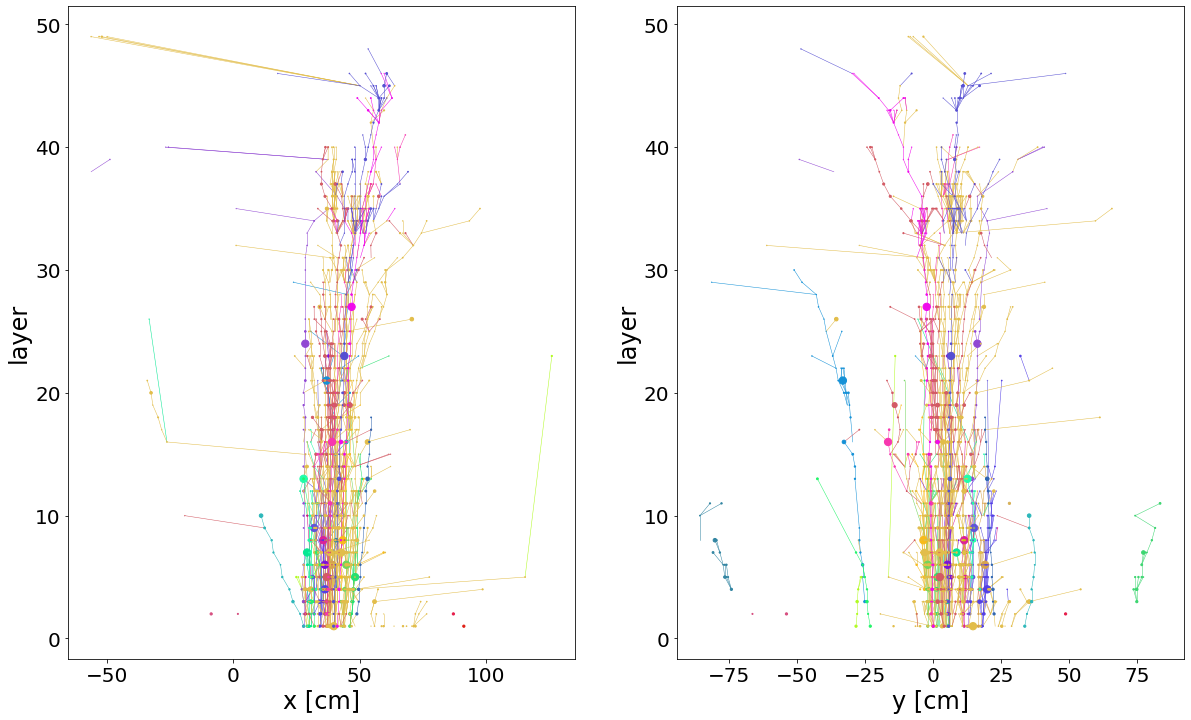

In [24]:
plot_edges(Event(pos_paths[0]), False, 0.01)

10


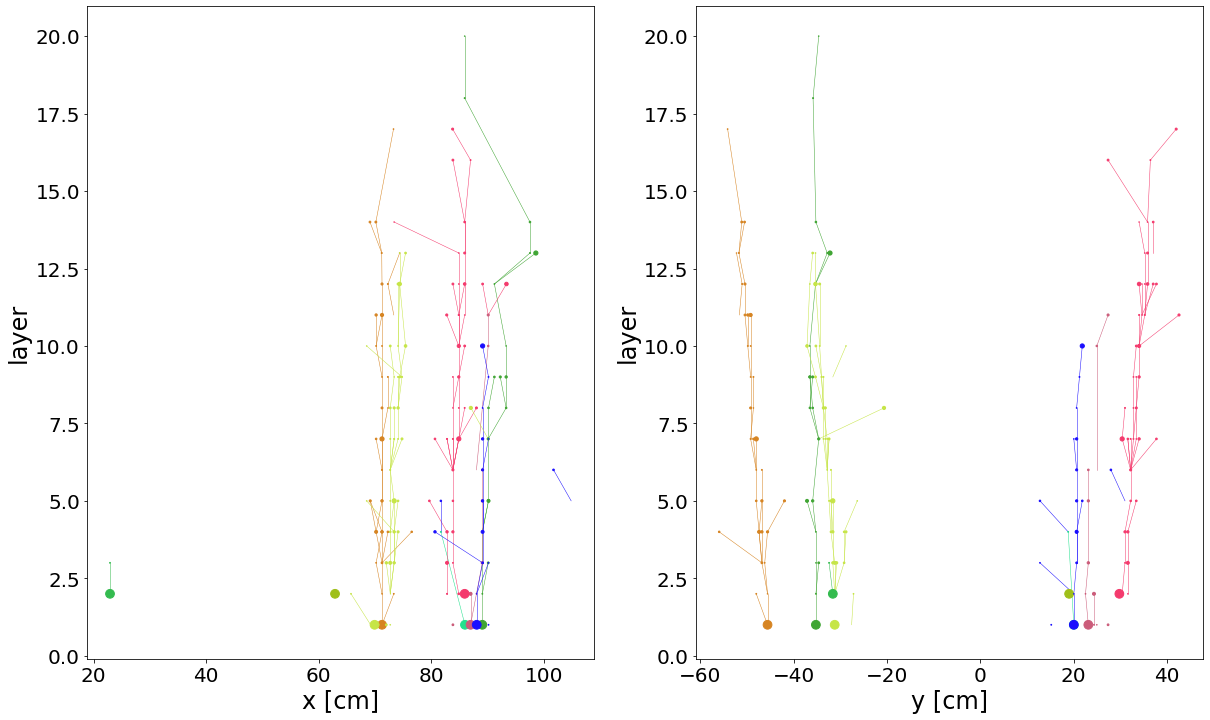

In [25]:
plot_edges(Event(pos_paths[50]), False, 0.01)

4


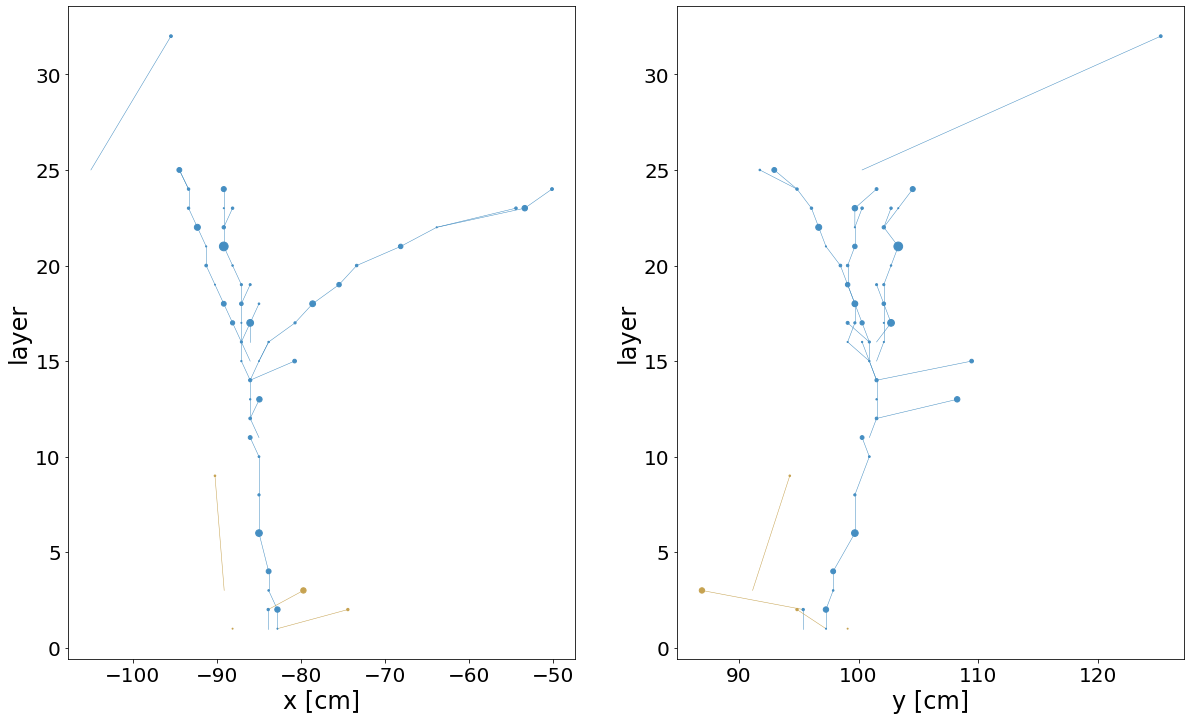

In [45]:
plot_edges(Event(neg_paths[205]), False, 0.01)

In [46]:
pos_event = next(EventLoader(pos_paths, n=1000))

In [47]:
pos_event.plot_event()

(<matplotlib.axes._subplots.AxesSubplot at 0x1bccb01ce08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bccb0e2508>)

(<matplotlib.axes._subplots.AxesSubplot at 0x1bccd3d07c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bccd2bc088>)

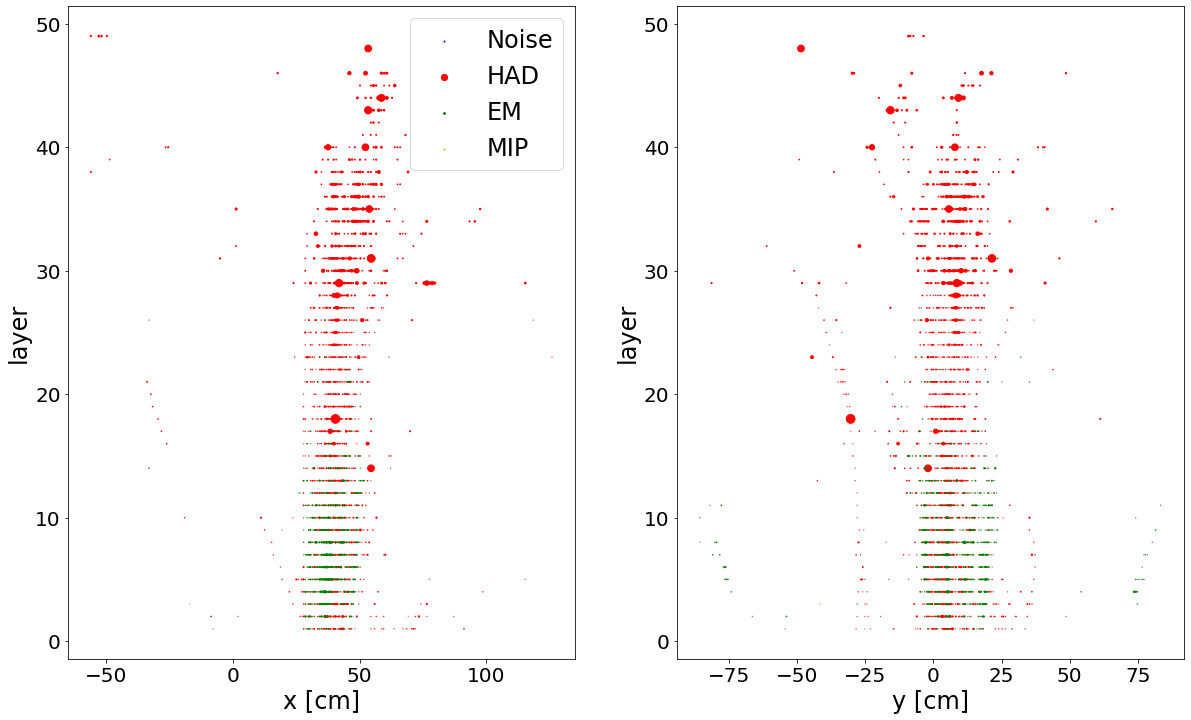

In [48]:
pos_event.plot_event(include_noise=False)

In [49]:
print(f'EM = {pos_event.num_particles(ParticleType.EM)}')
print(f'HAD = {pos_event.num_particles(ParticleType.HAD)}')
print(f'MIPs = {pos_event.num_particles(ParticleType.MIP)}')


EM = 17
HAD = 14
MIPs = 0


In [50]:
pos_event.plot_event(particle_type=ParticleType.HAD, include_noise=False, allowed_instances=[2])

(<matplotlib.axes._subplots.AxesSubplot at 0x1bcd087d5c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bcd088e3c8>)

In [51]:
pos_event.plot_event(particle_type=ParticleType.EM, include_noise=False, allowed_instances=[2])

(<matplotlib.axes._subplots.AxesSubplot at 0x1bcd0989248>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bccfab5b88>)

(<matplotlib.axes._subplots.AxesSubplot at 0x1bccad37b08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bcd119e088>)

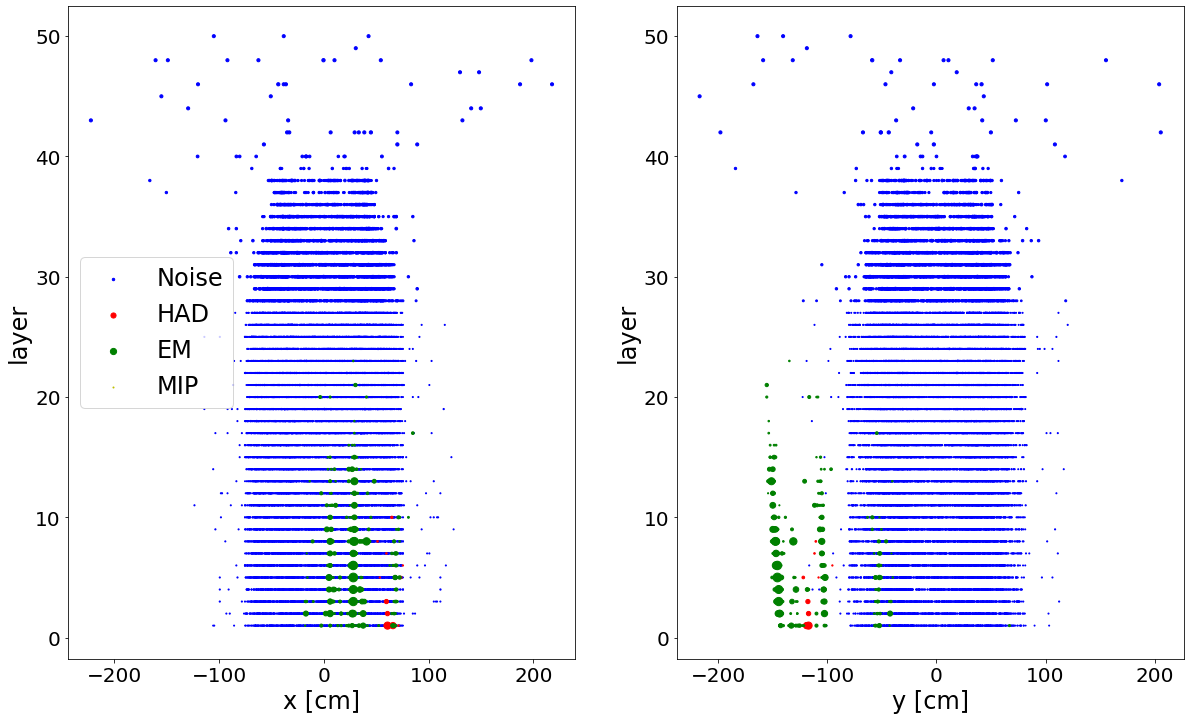

In [52]:
pos_event_2 = Event(pos_paths[100])
pos_event_2.plot_event()

(<matplotlib.axes._subplots.AxesSubplot at 0x1bccb292648>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bccb2a9708>)

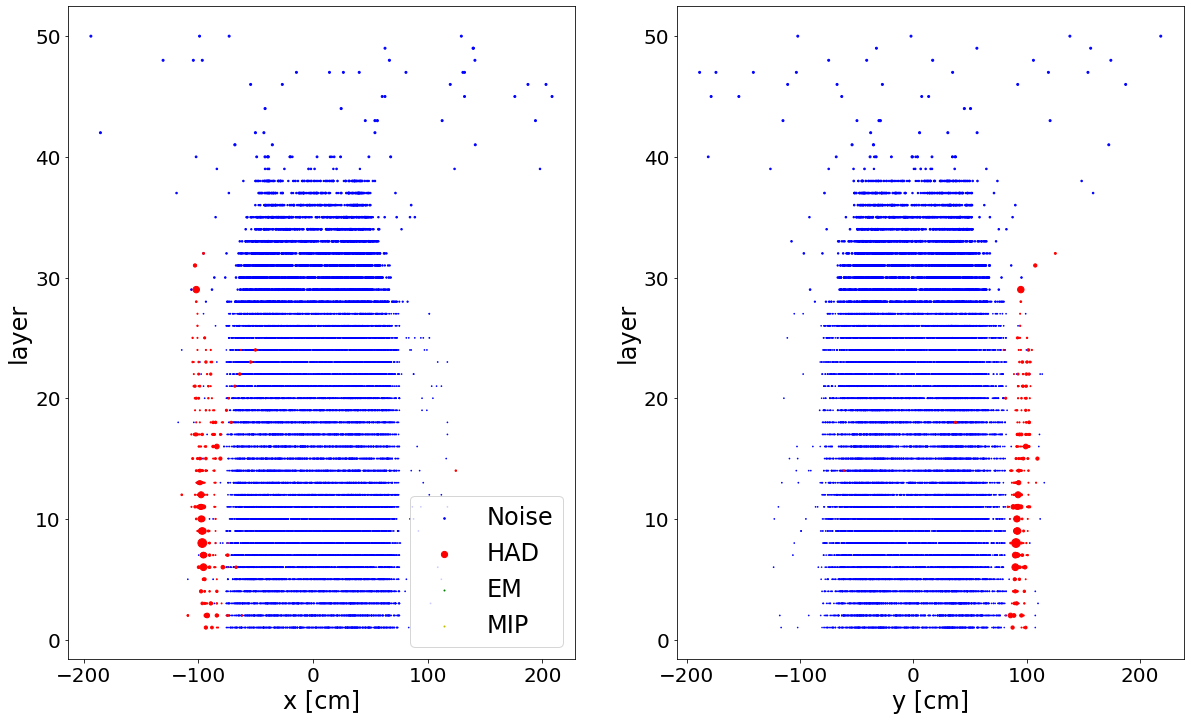

In [53]:
neg_event = Event(neg_paths[205])
neg_event.plot_event()

(<matplotlib.axes._subplots.AxesSubplot at 0x1bcc3703f88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bcc3a8c708>)

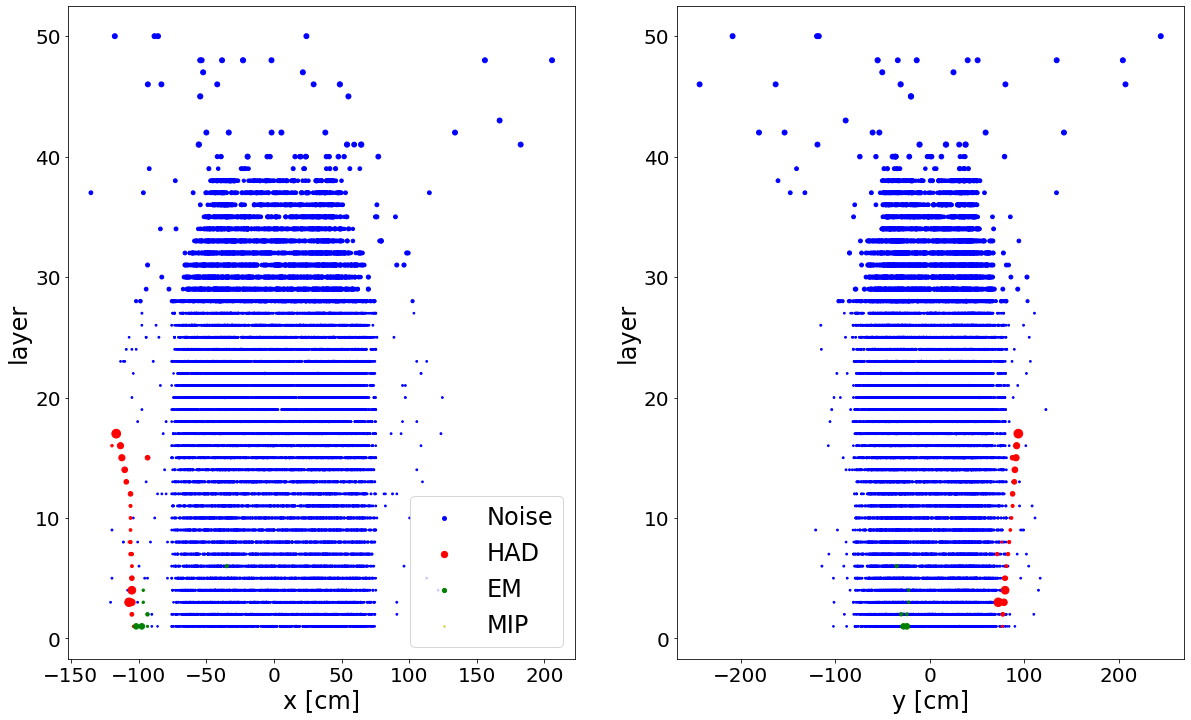

In [54]:
neg_event_2 = Event(neg_paths[6537])
neg_event_2.plot_event()